John Padworski </br>
Week 3 </br>
Micro Project #3

### Problem statement

We aim to understand which demographic and work-related factors are associated with higher income in the Adult Income dataset. Specifically, we will explore how variables such as age, education, occupation, work hours, marital status, and capital gains/losses relate to the probability that an individual’s annual income exceeds $50K. 


### Hypothesis

- H1 (Education): Individuals with higher education-num have a higher probability of income == >50K than those with lower education-num.

    - H0: Mean high-income rate is equal across education levels.

    - HA: Mean high-income rate increases with education level.

- H2 (Work hours): hours-per-week is positively associated with >50K income.

    - H0: Mean hours are equal between <=50K and >50K.

    - HA: Mean hours are higher in the >50K group.

- H3 (Marital status): Being married (e.g., Married-civ-spouse) is associated with a higher >50K rate compared with non-married categories.

    - H0: High-income rate is independent of marital status.

    - HA: High-income rate differs by marital status (expected higher for married).

- H4 (Occupation): occupation groups differ in high-income rates.

    - H0: High-income rate is equal across occupations.

    - HA: At least one occupation has a different high-income rate.

- H5 (Capital gains): Positive capital-gain is associated with higher odds of >50K.

    - H0: High-income rate is independent of having any capital gains.

    - HA: High-income rate is higher when capital-gain > 0.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score


In [4]:
CSV_PATH = r"adult_income.csv"  
df = pd.read_csv(CSV_PATH)

print("Shape:", df.shape)
df.head()


Shape: (32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
df.info()

#Numeric summary
df.describe(include=[np.number])

#Categorical peek: top categories for a few columns
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
{c: df[c].value_counts().head(5) for c in cat_cols[:8]}


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


{'workclass': workclass
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Name: count, dtype: int64,
 'education': education
 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 Name: count, dtype: int64,
 'marital-status': marital-status
 Married-civ-spouse    14976
 Never-married         10683
 Divorced               4443
 Separated              1025
 Widowed                 993
 Name: count, dtype: int64,
 'occupation': occupation
 Prof-specialty     4140
 Craft-repair       4099
 Exec-managerial    4066
 Adm-clerical       3770
 Sales              3650
 Name: count, dtype: int64,
 'relationship': relationship
 Husband          13193
 Not-in-family     8305
 Own-child         5068
 Unmarried         3446
 Wife              1568
 Name: count, dtype: int64,
 'race': race
 White                 27816
 Black                  3124
 Asian-Pac

In [6]:
#Replace '?' with NaN in object columns
df_clean = df.replace('?', np.nan).copy()

#Basic missingness overview
df_clean.isna().sum().sort_values(ascending=False).head(15)




occupation        1843
workclass         1836
native-country     583
age                  0
fnlwgt               0
education            0
education-num        0
marital-status       0
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
income               0
dtype: int64

In [7]:
#Simple imputation strategy:
#Categorical: fill missing with mode
#Numeric: fill missing with median 
for c in df_clean.columns:
    if pd.api.types.is_numeric_dtype(df_clean[c]):
        if df_clean[c].isna().any():
            df_clean[c] = df_clean[c].fillna(df_clean[c].median())
    else:
        mode_val = df_clean[c].mode(dropna=True)
        if not mode_val.empty:
            df_clean[c] = df_clean[c].fillna(mode_val.iloc[0])
        else:
            df_clean[c] = df_clean[c].fillna("Missing")

df_clean.isna().sum().sort_values(ascending=False).head(10)



age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
dtype: int64

In [8]:
#Drop exact duplicate rows
before = len(df_clean)
df_clean = df_clean.drop_duplicates()
after = len(df_clean)
print(f"Removed {before - after} duplicate rows. New shape: {df_clean.shape}")


Removed 24 duplicate rows. New shape: (32537, 15)


In [9]:
#Target: high_income (1 if >50K else 0)
df_feat = df_clean.copy()
df_feat["high_income"] = (df_feat["income"].str.strip() == ">50K").astype(int)

#Binary flags useful for analysis
df_feat["any_capital_gain"] = (df_feat["capital-gain"] > 0).astype(int)
df_feat["any_capital_loss"] = (df_feat["capital-loss"] > 0).astype(int)

#An example of grouping education levels via education-num (already numeric years-of-education proxy)
#Also create a tidy label for plotting
df_feat["education_num_label"] = df_feat["education-num"].astype(int).astype(str)

df_feat[["education","education-num","hours-per-week","income","high_income","any_capital_gain"]].head()


,education,education-num,hours-per-week,income,high_income,any_capital_gain
0,Bachelors,13,40,<=50K,0,1
1,Bachelors,13,13,<=50K,0,0
2,HS-grad,9,40,<=50K,0,0
3,11th,7,40,<=50K,0,0
4,Bachelors,13,40,<=50K,0,0


In [10]:
#IQR capping for highly skewed numerics (capital-gain, capital-loss, hours-per-week)
def iqr_cap(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    return series.clip(lower=low, upper=high)

for col in ["capital-gain", "capital-loss", "hours-per-week"]:
    if col in df_feat.columns and pd.api.types.is_numeric_dtype(df_feat[col]):
        df_feat[col + "_capped"] = iqr_cap(df_feat[col])

caps = [c for c in df_feat.columns if c.endswith("_capped")]
df_feat[caps].describe() if caps else "No caps created."


,capital-gain_capped,capital-loss_capped,hours-per-week_capped
count,32537.0,32537.0,32537.000000
mean,0.0,0.0,41.203246
std,0.0,0.0,6.187352
min,0.0,0.0,32.500000
25%,0.0,0.0,40.000000
50%,0.0,0.0,40.000000
75%,0.0,0.0,45.000000
max,0.0,0.0,52.500000


In [11]:
#High-income rate by education level
edu_rate = (df_feat.groupby("education-num")["high_income"]
            .mean()
            .sort_index())
edu_rate.head(10), edu_rate.tail(10)


(education-num
 1     0.000000
 2     0.036145
 3     0.048193
 4     0.062016
 5     0.052529
 6     0.066452
 7     0.051064
 8     0.076212
 9     0.159520
 10    0.190332
 Name: high_income, dtype: float64,
 education-num
 7     0.051064
 8     0.076212
 9     0.159520
 10    0.190332
 11    0.261216
 12    0.248360
 13    0.414908
 14    0.556911
 15    0.734375
 16    0.740920
 Name: high_income, dtype: float64)

In [12]:
#High-income rate by marital status
ms_rate = df_feat.groupby("marital-status")["high_income"].mean().sort_values(ascending=False)
ms_rate.head(10)


marital-status
Married-civ-spouse       0.446894
Married-AF-spouse        0.434783
Divorced                 0.104256
Widowed                  0.085599
Married-spouse-absent    0.081340
Separated                0.064390
Never-married            0.046030
Name: high_income, dtype: float64

In [13]:
#High-income rate by occupation
occ_rate = df_feat.groupby("occupation")["high_income"].mean().sort_values(ascending=False)
occ_rate.head(10)


occupation
Exec-managerial      0.484133
Prof-specialty       0.342699
Protective-serv      0.325116
Tech-support         0.305286
Sales                0.269315
Craft-repair         0.226917
Transport-moving     0.200376
Adm-clerical         0.134554
Machine-op-inspct    0.124500
Farming-fishing      0.115927
Name: high_income, dtype: float64

In [14]:
#Average hours-per-week by income group
df_feat.groupby("income")["hours-per-week"].mean().sort_values(ascending=False)


income
>50K     45.473402
<=50K    38.842862
Name: hours-per-week, dtype: float64

In [15]:
#Cross-tab: occupation × (high_income rate)
pivot_occ_edu = pd.pivot_table(
    df_feat,
    values="high_income",
    index="occupation",
    columns="education",
    aggfunc="mean"
)
pivot_occ_edu.round(3).head(10)


education,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college
occupation,,,,,,,,,,,,,,,,
Adm-clerical,0.000,0.045,0.026,NaN,0.000,0.091,0.071,0.155,0.108,0.235,0.400,0.119,0.338,0.0,0.444,0.111
Armed-Forces,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.000,1.000,NaN,NaN,0.000
Craft-repair,0.112,0.103,0.155,0.087,0.070,0.070,0.073,0.278,0.321,0.391,0.500,0.211,0.455,0.0,0.714,0.278
Exec-managerial,0.250,0.206,0.154,0.500,1.000,0.316,0.154,0.455,0.427,0.569,0.909,0.323,0.743,NaN,0.731,0.355
Farming-fishing,0.023,0.054,0.000,0.056,0.000,0.071,0.036,0.214,0.173,0.273,1.000,0.117,0.300,0.0,0.250,0.115
Handlers-cleaners,0.028,0.041,0.053,0.000,0.051,0.000,0.061,0.083,0.071,0.220,NaN,0.062,0.000,0.0,NaN,0.071
Machine-op-inspct,0.059,0.030,0.029,0.043,0.054,0.065,0.039,0.273,0.222,0.261,1.000,0.136,0.125,0.0,0.000,0.142
Other-service,0.005,0.025,0.012,0.000,0.000,0.010,0.020,0.077,0.078,0.160,1.000,0.041,0.053,0.0,0.250,0.033
Priv-house-serv,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.143,NaN,0.000,0.000,0.0,NaN,0.000


I sorted by education-num because it represents the natural progression of education levels. This makes it easier to observe trends in high-income rates across increasing education levels and directly supports testing our hypothesis about the relationship between education and income.

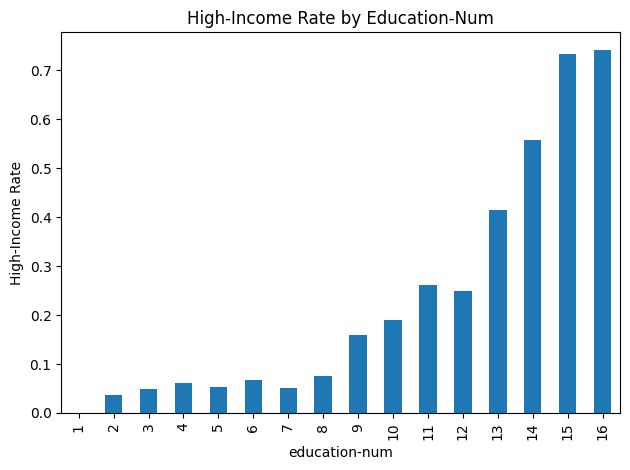

In [16]:
#High-income rate by education-num (ordered)
plt.figure()
edu_rate.plot(kind="bar", title="High-Income Rate by Education-Num")
plt.xlabel("education-num")
plt.ylabel("High-Income Rate")
plt.tight_layout()
plt.show()


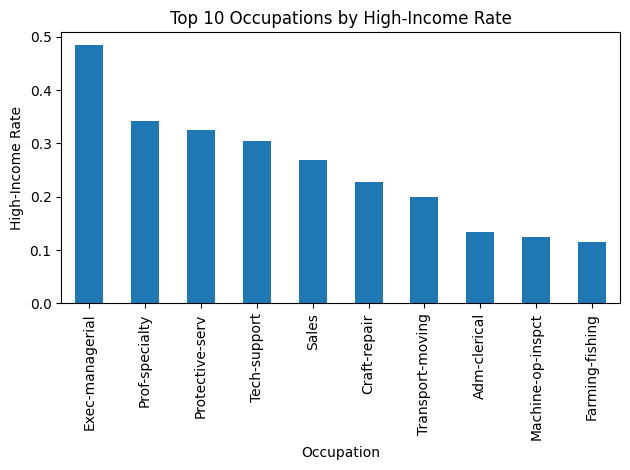

In [17]:
#Top 10 occupations by high-income rate (drop NaNs)
top_occ = occ_rate.dropna().head(10)
plt.figure()
top_occ.plot(kind="bar", title="Top 10 Occupations by High-Income Rate")
plt.xlabel("Occupation")
plt.ylabel("High-Income Rate")
plt.tight_layout()
plt.show()


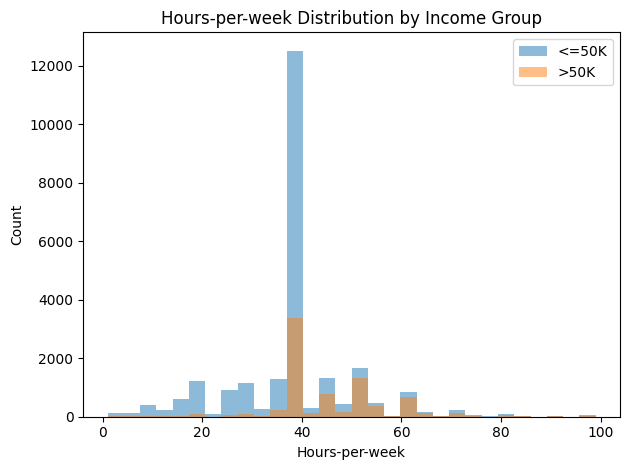

In [18]:
#Hours-per-week distribution by income group (simple overlaid histograms)
plt.figure()
for label, g in df_feat.groupby("income"):
    g["hours-per-week"].plot(kind="hist", alpha=0.5, bins=30, label=label)
plt.title("Hours-per-week Distribution by Income Group")
plt.xlabel("Hours-per-week")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
from scipy import stats

#H2: t-test on hours-per-week between <=50K and >50K
g0 = df_feat.loc[df_feat["high_income"] == 0, "hours-per-week"].dropna()
g1 = df_feat.loc[df_feat["high_income"] == 1, "hours-per-week"].dropna()

tstat, pval = stats.ttest_ind(g1, g0, equal_var=False)
print(f"H2 t-test (hours-per-week): t={tstat:.3f}, p={pval:.3g} (n>50K={len(g1)}, n<=50K={len(g0)})")


H2 t-test (hours-per-week): t=45.095, p=0 (n>50K=7839, n<=50K=24698)


In [20]:
#H3: Chi-square test of independence for marital-status vs high_income
ct_ms = pd.crosstab(df_feat["marital-status"], df_feat["high_income"])
chi2, p, dof, exp = stats.chi2_contingency(ct_ms)
print("H3 Chi-square (marital-status ~ high_income):")
print(f"chi2={chi2:.3f}, dof={dof}, p={p:.3g}")
ct_ms.head()


H3 Chi-square (marital-status ~ high_income):
chi2=6510.332, dof=6, p=0


high_income,0,1
marital-status,,
Divorced,3978,463
Married-AF-spouse,13,10
Married-civ-spouse,8280,6690
Married-spouse-absent,384,34
Never-married,10176,491


In [21]:
#H4: Chi-square test for occupation vs high_income
ct_occ = pd.crosstab(df_feat["occupation"], df_feat["high_income"])
chi2, p, dof, exp = stats.chi2_contingency(ct_occ)
print("H4 Chi-square (occupation ~ high_income):")
print(f"chi2={chi2:.3f}, dof={dof}, p={p:.3g}")
ct_occ.head()


H4 Chi-square (occupation ~ high_income):
chi2=3197.613, dof=13, p=0


high_income,0,1
occupation,,
Adm-clerical,3261,507
Armed-Forces,8,1
Craft-repair,3165,929
Exec-managerial,2097,1968
Farming-fishing,877,115


In [22]:
#H5: Chi-square for any capital gain vs high_income
ct_gain = pd.crosstab(df_feat["any_capital_gain"], df_feat["high_income"])
chi2, p, dof, exp = stats.chi2_contingency(ct_gain)
print("H5 Chi-square (any_capital_gain ~ high_income):")
print(f"chi2={chi2:.3f}, dof={dof}, p={p:.3g}")
ct_gain


H5 Chi-square (any_capital_gain ~ high_income):
chi2=2302.418, dof=1, p=0


high_income,0,1
any_capital_gain,,
0,23663,6162
1,1035,1677


In [36]:
TARGET = "high_income"
def show_title(t):
    print("\n" + "="*len(t) + f"\n{t}\n" + "="*len(t))

show_title("Data Quality Summary")

dq = []
for c in df_feat.columns:
    miss = df_feat[c].isna().mean()
    nunique = df_feat[c].nunique(dropna=True)
    dtype = df_feat[c].dtype
    coltype = ("numeric" if pd.api.types.is_numeric_dtype(df_feat[c]) else "categorical")
    dq.append({"column": c, "dtype": str(dtype), "type": coltype, "missing_rate": miss, "nunique": nunique})
dq = pd.DataFrame(dq).sort_values(["type","missing_rate","nunique"], ascending=[True, False, False])
dq



Data Quality Summary


,column,dtype,type,missing_rate,nunique
13,native-country,object,categorical,0.0,41
3,education,object,categorical,0.0,16
18,education_num_label,object,categorical,0.0,16
6,occupation,object,categorical,0.0,14
1,workclass,object,categorical,0.0,8
5,marital-status,object,categorical,0.0,7
7,relationship,object,categorical,0.0,6
8,race,object,categorical,0.0,5
9,sex,object,categorical,0.0,2
14,income,object,categorical,0.0,2


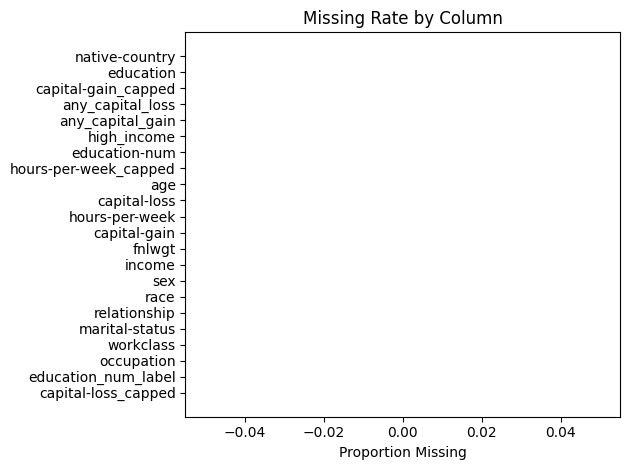

In [37]:
#Missingness
top_miss = dq.sort_values("missing_rate", ascending=False).head(25)
plt.figure()
plt.barh(top_miss["column"][::-1], top_miss["missing_rate"][::-1])
plt.title("Missing Rate by Column")
plt.xlabel("Proportion Missing")
plt.tight_layout(); plt.show()



Univariate Numeric Distributions (with target overlays)


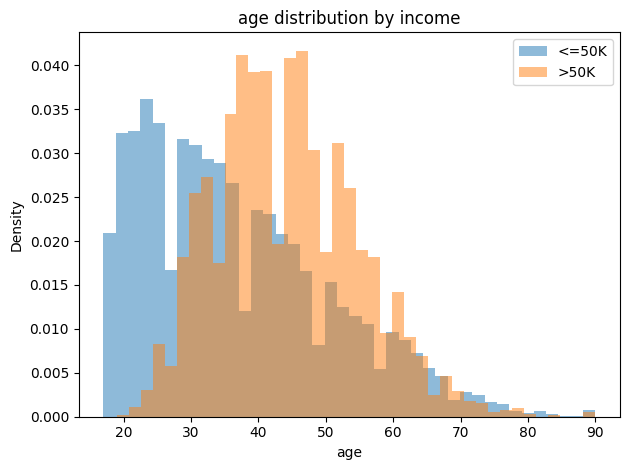

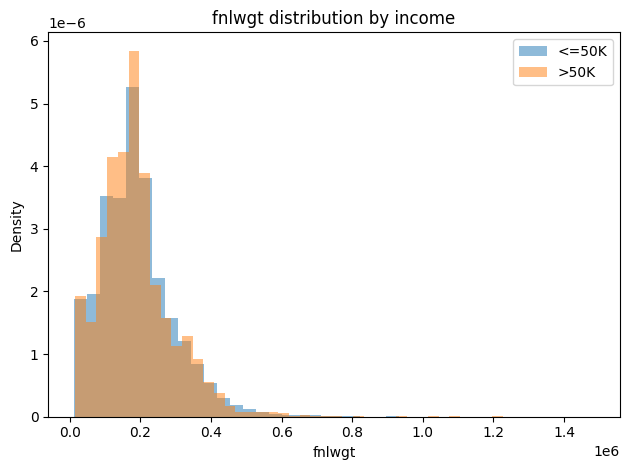

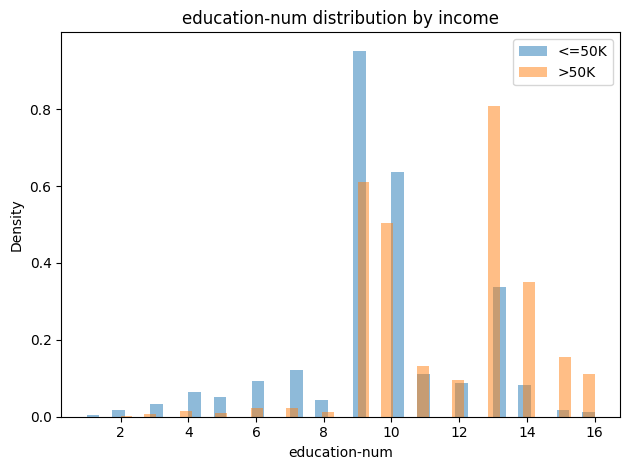

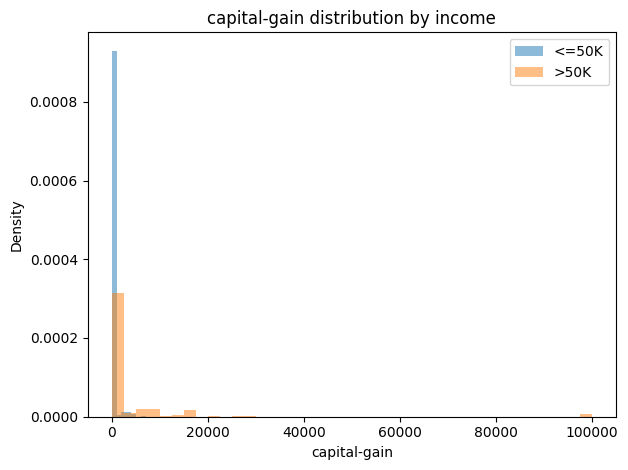

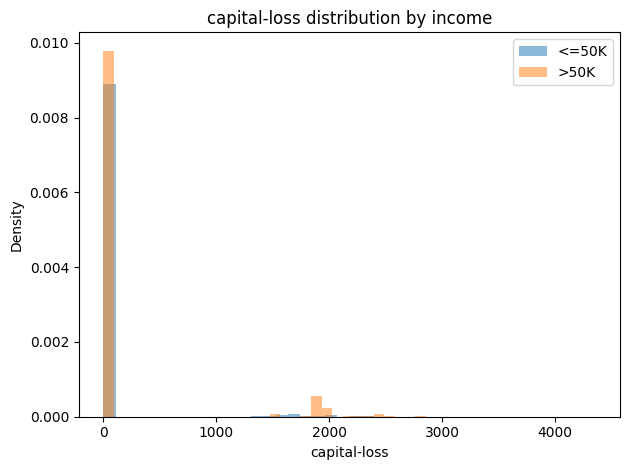

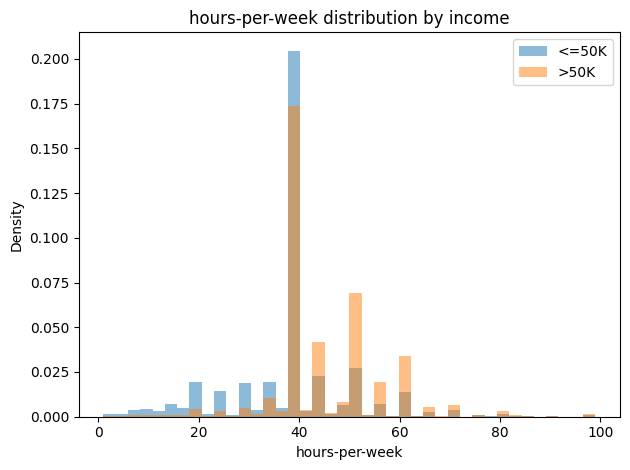

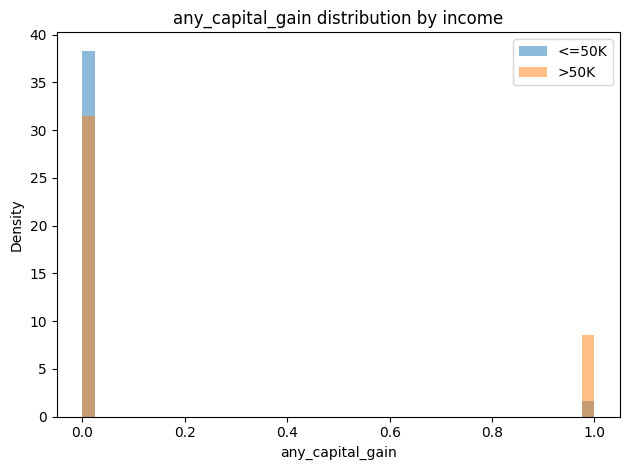

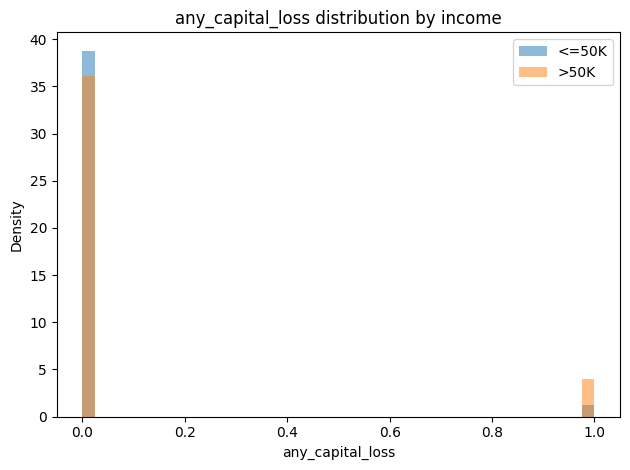

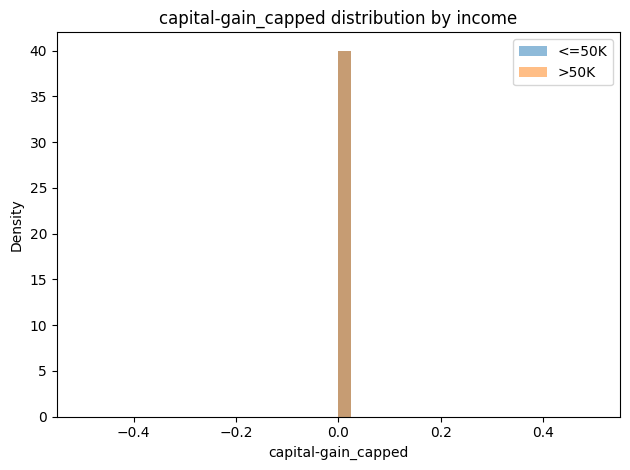

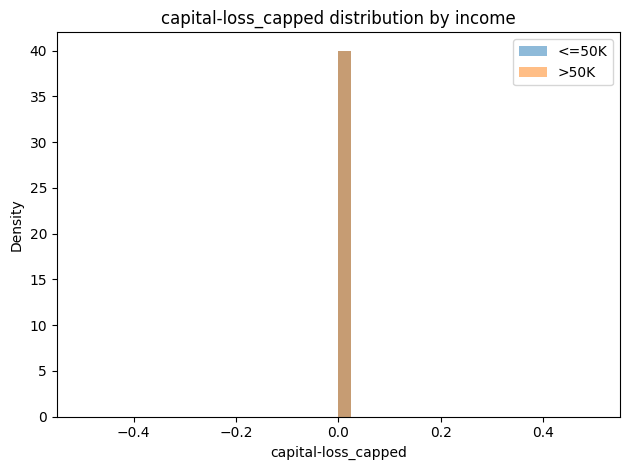

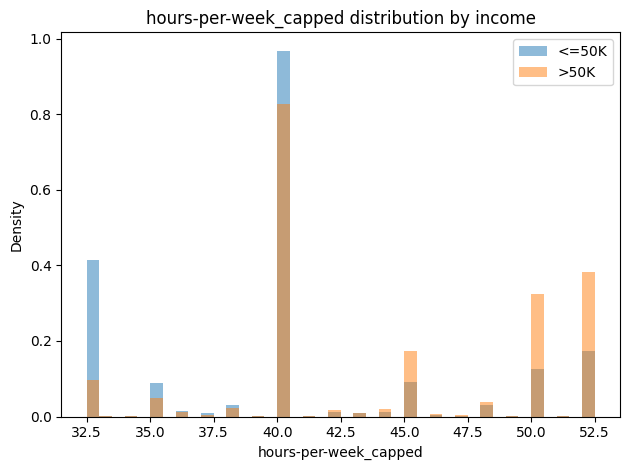

In [38]:
show_title("Univariate Numeric Distributions (with target overlays)")
num_cols = [c for c in df_feat.select_dtypes(include=[np.number]).columns if c != TARGET]

for c in num_cols:
    plt.figure()
    a = df_feat.loc[df_feat[TARGET]==0, c].dropna()
    b = df_feat.loc[df_feat[TARGET]==1, c].dropna()
    plt.hist(a, bins=40, alpha=0.5, label="<=50K", density=True)
    plt.hist(b, bins=40, alpha=0.5, label=">50K", density=True)
    plt.title(f"{c} distribution by income")
    plt.xlabel(c); plt.ylabel("Density"); plt.legend(); plt.tight_layout(); plt.show()



Numeric Correlations (Spearman)


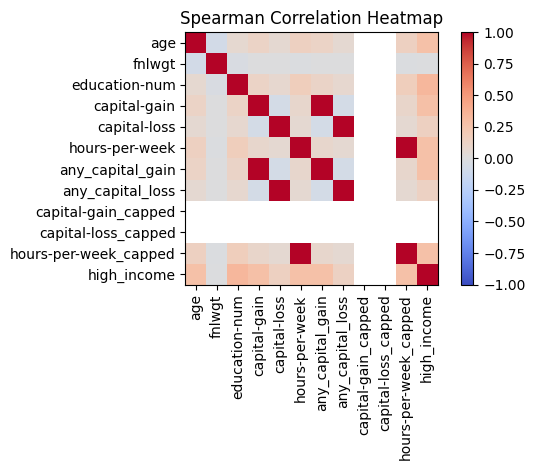

In [40]:
show_title("Numeric Correlations (Spearman)")
num_df = df_feat[num_cols + [TARGET]].copy()
corr = num_df.corr(method="spearman")
plt.figure()
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar(); plt.title("Spearman Correlation Heatmap")
plt.tight_layout(); plt.show()




In [45]:
show_title("Target-Aware Feature Screening")

X_screen = df_feat[num_cols + cat_cols].copy()
y_screen = df_feat[TARGET].astype(int).values

X_ohe_df = pd.get_dummies(X_screen[cat_cols], dummy_na=False)
X_mi_df = pd.concat([X_screen[num_cols].reset_index(drop=True), X_ohe_df.reset_index(drop=True)], axis=1)

discrete_mask = np.array([False] * len(num_cols) + [True] * X_ohe_df.shape[1])

mi = mutual_info_classif(X_mi_df.values, y_screen, discrete_features=discrete_mask, random_state=42)
mi_series = pd.Series(mi, index=list(X_mi_df.columns)).sort_values(ascending=False)
mi_series.head(25)


Target-Aware Feature Screening


marital-status_Married-civ-spouse    0.105396
capital-gain                         0.081535
relationship_Husband                 0.080843
age                                  0.069509
education-num                        0.066710
marital-status_Never-married         0.061888
hours-per-week                       0.042381
hours-per-week_capped                0.039446
relationship_Own-child               0.038234
capital-loss                         0.033343
fnlwgt                               0.032451
any_capital_gain                     0.028103
sex_Female                           0.025761
sex_Male                             0.025761
occupation_Exec-managerial           0.020305
relationship_Not-in-family           0.020138
occupation_Other-service             0.016418
education_Bachelors                  0.014821
education_num_label_13               0.014821
relationship_Unmarried               0.012960
education_num_label_14               0.012894
education_Masters                 

In [49]:
show_title("Consolidate Rare Levels (<1% each)")

def collapse_rare_levels(df, cols, min_freq=0.01, other_label="Other"):
    df2 = df.copy()
    n = len(df2)
    for c in cols:
        vc = df2[c].value_counts(dropna=False) / n
        rare = vc[vc < min_freq].index
        if len(rare) > 0:
            df2[c] = df2[c].where(~df2[c].isin(rare), other_label)
    return df2

df_feat2 = collapse_rare_levels(df_feat, cat_cols, min_freq=0.01)
for c in cat_cols[:5]:
    display(df_feat[c].value_counts().head(5), df_feat2[c].value_counts().head(5))



Consolidate Rare Levels (<1% each)


workclass
Private             24509
Self-emp-not-inc     2540
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Name: count, dtype: int64

workclass
Private             24509
Self-emp-not-inc     2540
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Name: count, dtype: int64

education
HS-grad         10494
Some-college     7282
Bachelors        5353
Masters          1722
Assoc-voc        1382
Name: count, dtype: int64

education
HS-grad         10494
Some-college     7282
Bachelors        5353
Masters          1722
Assoc-voc        1382
Name: count, dtype: int64

marital-status
Married-civ-spouse    14970
Never-married         10667
Divorced               4441
Separated              1025
Widowed                 993
Name: count, dtype: int64

marital-status
Married-civ-spouse    14970
Never-married         10667
Divorced               4441
Separated              1025
Widowed                 993
Name: count, dtype: int64

occupation
Prof-specialty     5979
Craft-repair       4094
Exec-managerial    4065
Adm-clerical       3768
Sales              3650
Name: count, dtype: int64

occupation
Prof-specialty     5979
Craft-repair       4094
Exec-managerial    4065
Adm-clerical       3768
Sales              3650
Name: count, dtype: int64

relationship
Husband          13187
Not-in-family     8292
Own-child         5064
Unmarried         3445
Wife              1568
Name: count, dtype: int64

relationship
Husband          13187
Not-in-family     8292
Own-child         5064
Unmarried         3445
Wife              1568
Name: count, dtype: int64


Domain Grouping: native-country -> region


,rate,count
country_region,,
NorthAmerica,0.241917,30374
OtherRegion,0.227000,2163


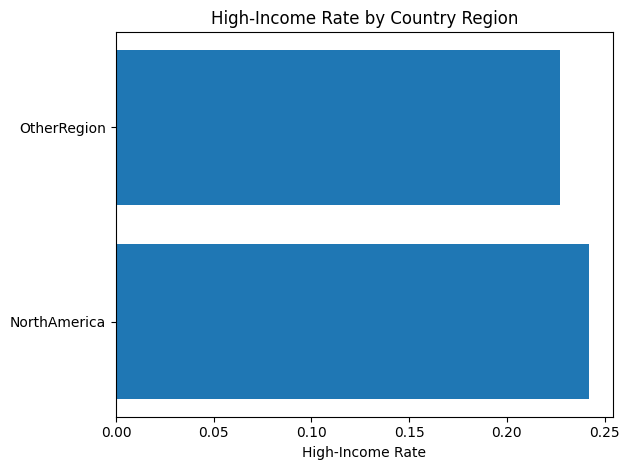

In [51]:
show_title("Domain Grouping: native-country -> region")
if "native-country" in df_feat2.columns:
    region_map = {
        "United-States": "NorthAmerica", "Canada": "NorthAmerica", "Mexico": "NorthAmerica",
        "India": "Asia", "China": "Asia", "Japan": "Asia", "Philippines": "Asia", "Vietnam": "Asia",
        "England": "Europe", "Germany": "Europe", "Italy": "Europe", "France": "Europe",
    }
    df_feat2["country_region"] = df_feat2["native-country"].map(region_map).fillna("OtherRegion")
    g = df_feat2.groupby("country_region")[TARGET].agg(rate="mean", count="size").sort_values("rate", ascending=False)
    display(g)

    plt.figure()
    plt.barh(g.index, g["rate"])
    plt.title("High-Income Rate by Country Region")
    plt.xlabel("High-Income Rate"); plt.tight_layout(); plt.show()



Numeric Binning for Reporting


C:\Users\john_\AppData\Local\Temp\ipykernel_33616\1364732681.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = df_feat2.groupby(qs)[TARGET].mean()


age
(16.999, 26.0]    0.024635
(26.0, 33.0]      0.179074
(33.0, 41.0]      0.313757
(41.0, 50.0]      0.384989
(50.0, 90.0]      0.324818
Name: high_income, dtype: float64

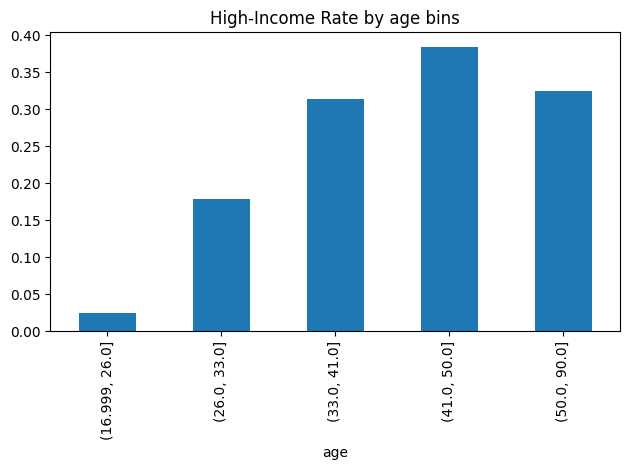

C:\Users\john_\AppData\Local\Temp\ipykernel_33616\1364732681.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = df_feat2.groupby(qs)[TARGET].mean()


hours-per-week
(0.999, 35.0]    0.084667
(35.0, 40.0]     0.211475
(40.0, 48.0]     0.346179
(48.0, 99.0]     0.429408
Name: high_income, dtype: float64

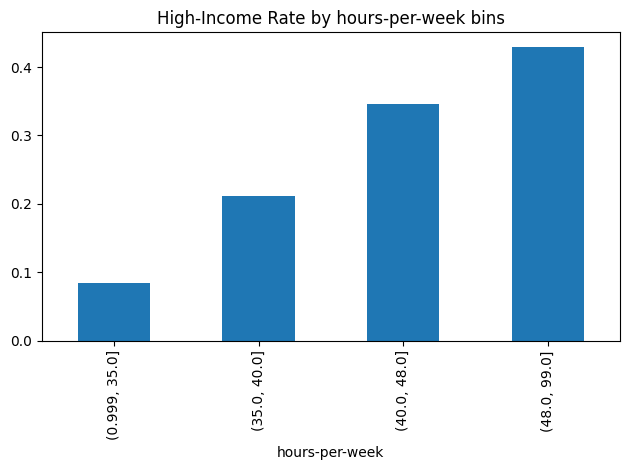

In [56]:
show_title("Numeric Binning for Reporting")
def bin_numeric(col, q=5, labels=None):
    qs = pd.qcut(df_feat2[col], q=q, duplicates="drop", labels=labels)
    t = df_feat2.groupby(qs)[TARGET].mean()
    display(t)
    plt.figure(); t.plot(kind="bar"); plt.title(f"High-Income Rate by {col} bins"); plt.tight_layout(); plt.show()
    return qs

if "age" in df_feat2: df_feat2["age_bin"] = bin_numeric("age", q=5)
if "hours-per-week" in df_feat2: df_feat2["hours_bin"] = bin_numeric("hours-per-week", q=5)


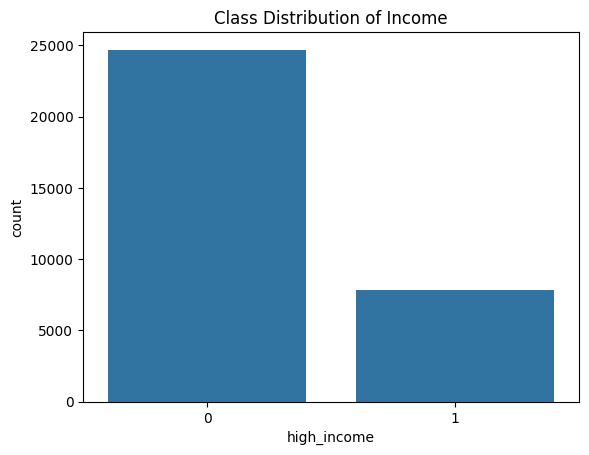

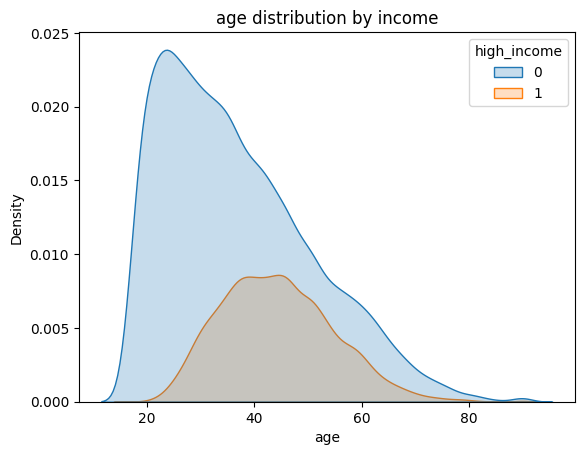

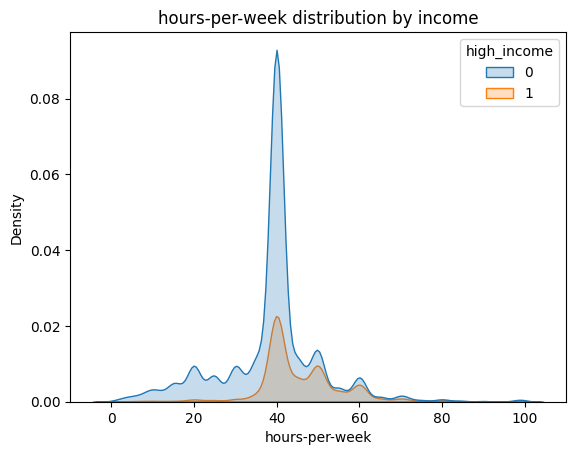

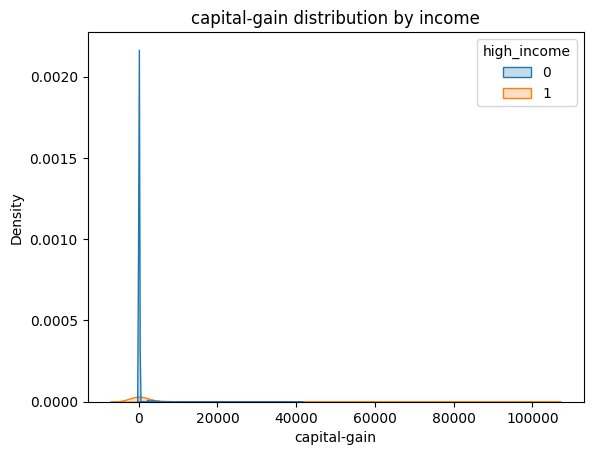

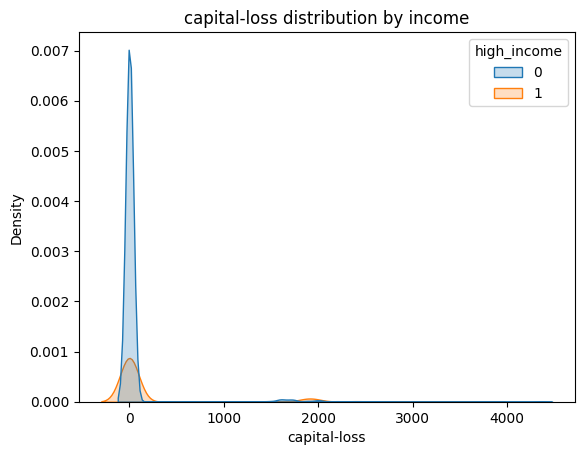

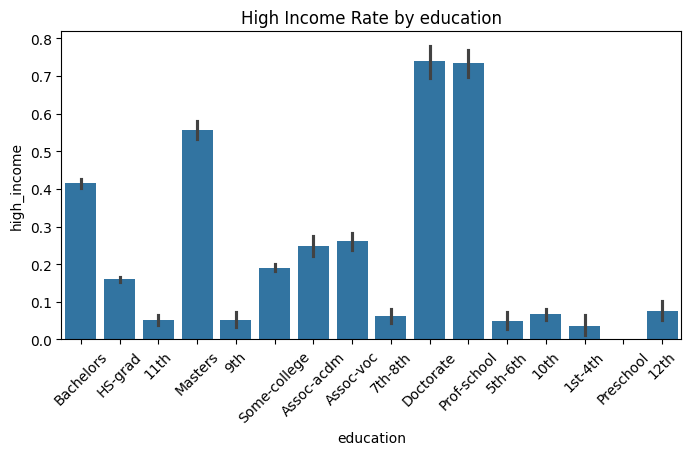

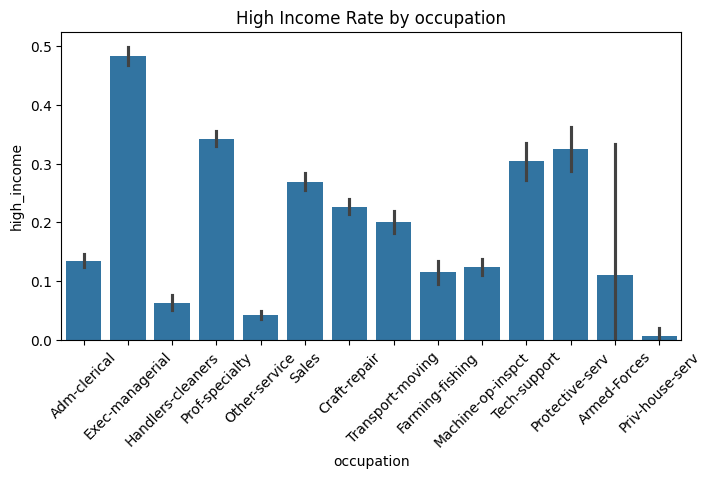

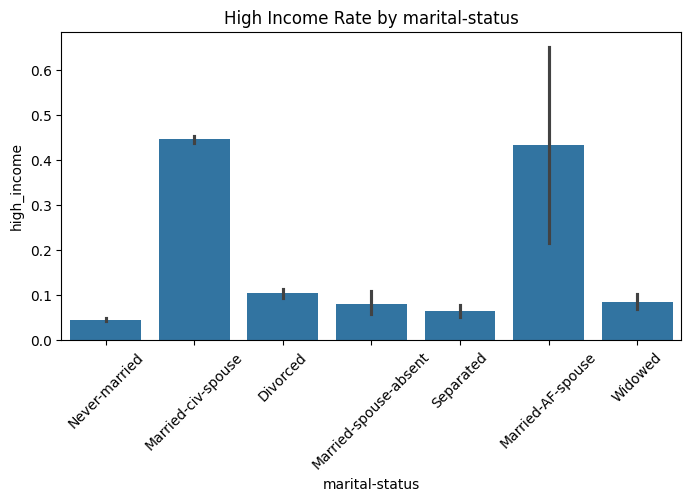

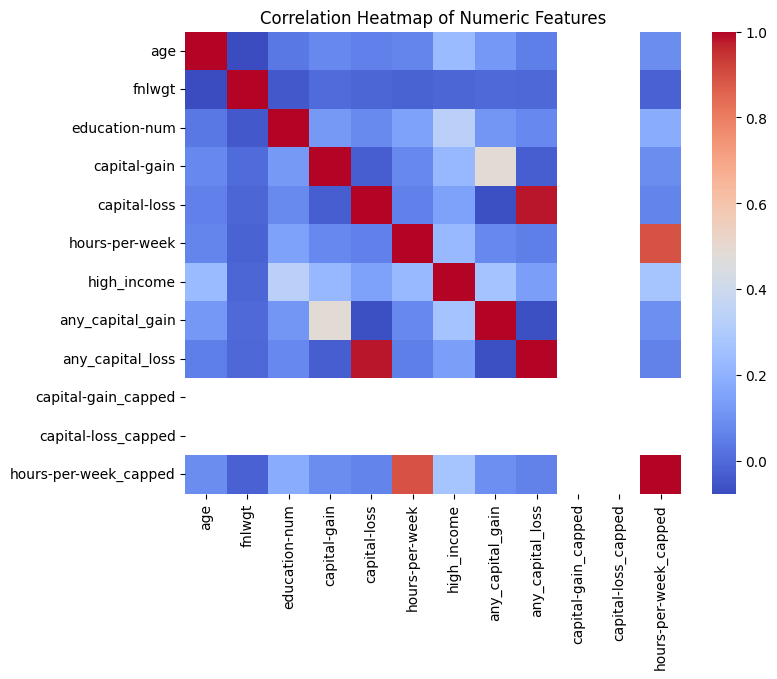

In [70]:
# Income balance
sns.countplot(x='high_income', data=df_feat)
plt.title('Class Distribution of Income')
plt.show()

# Numeric feature distribution
numeric_features = ['age', 'hours-per-week', 'capital-gain', 'capital-loss']
for col in numeric_features:
    sns.kdeplot(data=df_feat, x=col, hue='high_income', fill=True)
    plt.title(f'{col} distribution by income')
    plt.show()

# Categorical analysis
cat_features = ['education', 'occupation', 'marital-status']
for col in cat_features:
    plt.figure(figsize=(8,4))
    sns.barplot(data=df_feat, x=col, y='high_income')
    plt.title(f'High Income Rate by {col}')
    plt.xticks(rotation=45)
    plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df_feat.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


In [60]:

#target
y = df_feat["high_income"].astype(int)

#features
num_candidates = ["age", "education-num", "hours-per-week", "capital-gain", "capital-loss"]
cat_candidates = ["workclass", "marital-status", "occupation", "relationship", "race", "sex", "native-country", "education"]

num_features = [c for c in num_candidates if c in df_feat.columns]
cat_features = [c for c in cat_candidates if c in df_feat.columns]

X = df_feat[num_features + cat_features].copy()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

numeric_pipe = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_features),
        ("cat", categorical_pipe, cat_features),
    ]
)

print("Train class balance (>%50K rate):", round(float(y_train.mean()), 3))
print("Test  class balance (>%50K rate):", round(float(y_test.mean()), 3))


Train class balance (>%50K rate): 0.241
Test  class balance (>%50K rate): 0.241


#### Baseline model

In [61]:
baseline = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", DummyClassifier(strategy="most_frequent"))
])
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)
y_prob_base = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)  # flat probs

def metric_summary(y_true, y_pred, y_prob):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan,
        "pr_auc": average_precision_score(y_true, y_prob)
    }

base_metrics = metric_summary(y_test, y_pred_base, y_prob_base)
pd.DataFrame([base_metrics], index=["Baseline"])


,accuracy,precision,recall,f1,roc_auc,pr_auc
Baseline,0.759066,0.0,0.0,0.0,0.5,0.240934


#### Logistic Regression

In [62]:
log_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000, solver="liblinear", class_weight="balanced"  # handles imbalance
    ))
])
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

lr_metrics = metric_summary(y_test, y_pred_lr, y_prob_lr)
pd.DataFrame([base_metrics, lr_metrics], index=["Baseline","LogisticRegression"]).round(3)


,accuracy,precision,recall,f1,roc_auc,pr_auc
Baseline,0.759,0.000,0.000,0.000,0.50,0.241
LogisticRegression,0.809,0.568,0.858,0.684,0.91,0.773


#### Random Forest

In [63]:
rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_leaf=2,
        random_state=42, class_weight="balanced_subsample"
    ))
])
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

rf_metrics = metric_summary(y_test, y_pred_rf, y_prob_rf)
pd.DataFrame([base_metrics, lr_metrics, rf_metrics],
             index=["Baseline","LogisticRegression","RandomForest"]).round(3)


,accuracy,precision,recall,f1,roc_auc,pr_auc
Baseline,0.759,0.000,0.000,0.000,0.50,0.241
LogisticRegression,0.809,0.568,0.858,0.684,0.91,0.773
RandomForest,0.834,0.613,0.843,0.710,0.92,0.803


#### ROC Curves and Precision Recall

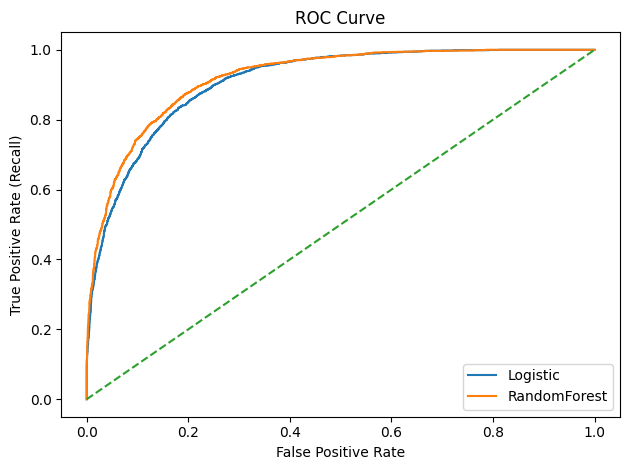

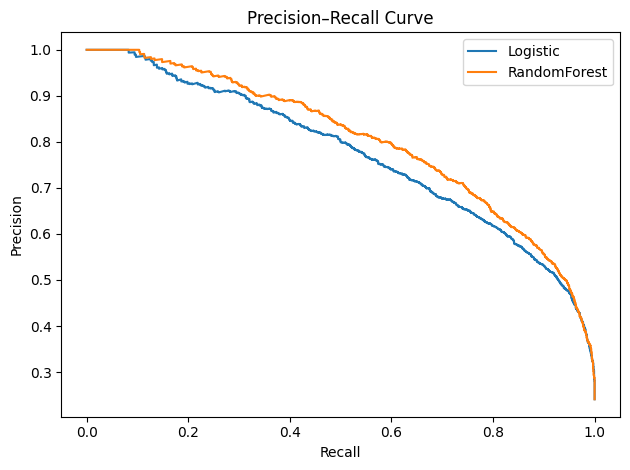

In [64]:
plt.figure()
for label, y_prob in [
    ("Logistic", y_prob_lr),
    ("RandomForest", y_prob_rf)
]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{label}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for label, y_prob in [
    ("Logistic", y_prob_lr),
    ("RandomForest", y_prob_rf)
]:
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(rec, prec, label=f"{label}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()


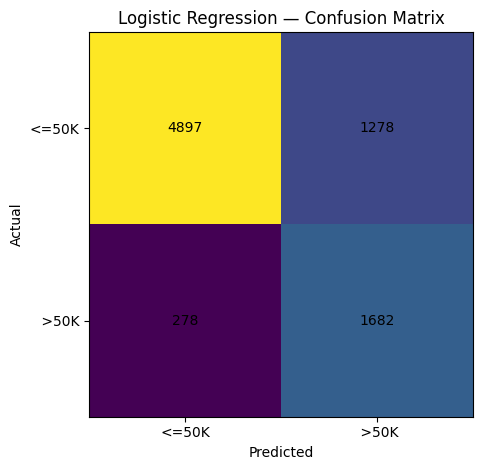

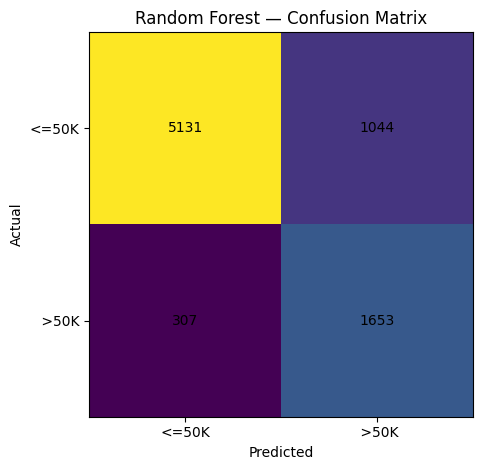

(array([[4897, 1278],
        [ 278, 1682]], dtype=int64),
 array([[5131, 1044],
        [ 307, 1653]], dtype=int64))

In [65]:
def plot_confusion(y_true, y_prob, threshold=0.5, title="Confusion Matrix"):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    # Simple matplotlib heatmap
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xticks([0,1], ["<=50K"," >50K"])
    plt.yticks([0,1], ["<=50K"," >50K"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    return cm

cm_lr = plot_confusion(y_test, y_prob_lr, 0.5, "Logistic Regression — Confusion Matrix")
cm_rf = plot_confusion(y_test, y_prob_rf, 0.5, "Random Forest — Confusion Matrix")
cm_lr, cm_rf


#### Cross validation (ROC-AUC & PR-AUC)

In [66]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_metrics(pipe, X, y, cv):
    roc = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc")
    pr  = cross_val_score(pipe, X, y, cv=cv, scoring="average_precision")
    return pd.Series({
        "ROC-AUC mean": roc.mean(), "ROC-AUC std": roc.std(),
        "PR-AUC mean": pr.mean(),   "PR-AUC std": pr.std()
    })

cv_lr = cv_metrics(log_reg, X, y, cv)
cv_rf = cv_metrics(rf, X, y, cv)
pd.DataFrame([cv_lr, cv_rf], index=["LogisticRegression","RandomForest"]).round(3)


,ROC-AUC mean,ROC-AUC std,PR-AUC mean,PR-AUC std
LogisticRegression,0.905,0.002,0.763,0.007
RandomForest,0.916,0.002,0.792,0.005


,feature,coef
3,capital-gain,2.209021
15,marital-status_Married-civ-spouse,1.425907
47,native-country_Cambodia,1.211263
14,marital-status_Married-AF-spouse,1.177699
39,relationship_Wife,1.132904
23,occupation_Exec-managerial,0.854998
1,education-num,0.765372
91,education_1st-4th,0.704266
32,occupation_Tech-support,0.698803
30,occupation_Protective-serv,0.698347


,feature,coef
28,occupation_Priv-house-serv,-1.704988
81,native-country_South,-1.387032
12,workclass_Without-pay,-1.170923
17,marital-status_Never-married,-1.081065
52,native-country_Dominican-Republic,-1.068629
50,native-country_Columbia,-1.056266
37,relationship_Own-child,-1.028096
24,occupation_Farming-fishing,-0.914412
45,sex_Female,-0.877836
101,education_Preschool,-0.841229


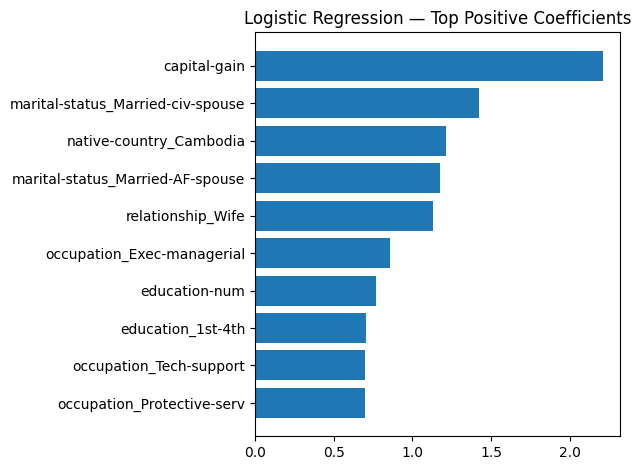

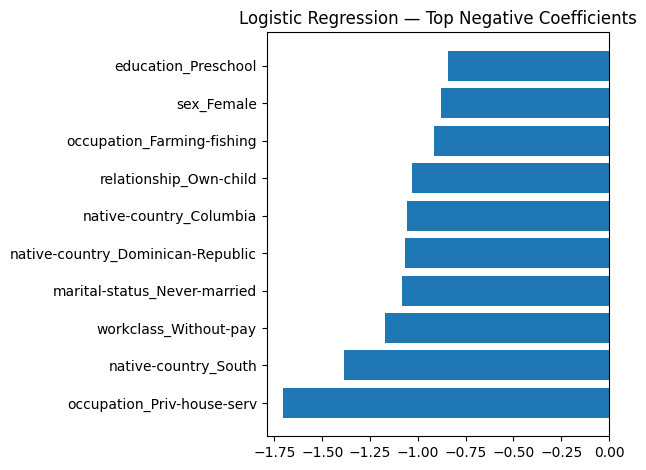

In [ ]:
prep = log_reg.named_steps["prep"]
ohe = prep.named_transformers_["cat"].named_steps["onehot"]
num_names = num_features
cat_names = ohe.get_feature_names_out(cat_features).tolist()
feature_names = num_names + cat_names

coef = log_reg.named_steps["clf"].coef_[0]
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef}).sort_values("coef", ascending=False)

top_pos = coef_df.head(10)
top_neg = coef_df.tail(10).sort_values("coef")

display(top_pos)
display(top_neg)

#Plotting top positive & negative coefficients
plt.figure()
plt.barh(top_pos["feature"][::-1], top_pos["coef"][::-1])
plt.title("Logistic Regression — Top Positive Coefficients")
plt.tight_layout()
plt.show()

plt.figure()
plt.barh(top_neg["feature"], top_neg["coef"])
plt.title("Logistic Regression — Top Negative Coefficients")
plt.tight_layout()
plt.show()


#### Random Forest feature importance

,feature,importance
0,age,0.123523
15,marital-status_Married-civ-spouse,0.116299
1,education-num,0.092746
34,relationship_Husband,0.087675
3,capital-gain,0.086159
2,hours-per-week,0.067159
17,marital-status_Never-married,0.062300
37,relationship_Own-child,0.028299
4,capital-loss,0.022389
35,relationship_Not-in-family,0.021977


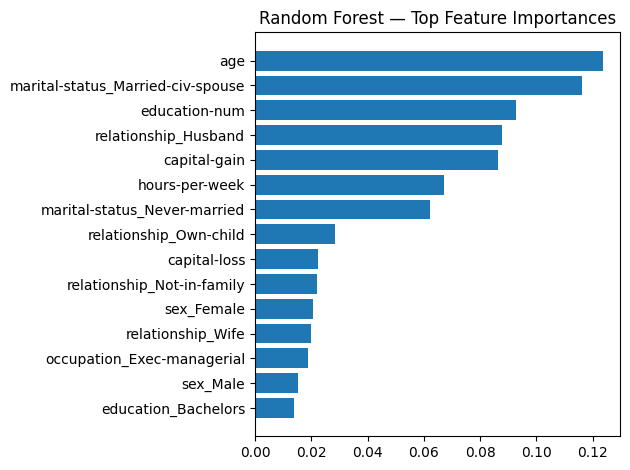

In [ ]:
rf_clf = rf.named_steps["clf"]
rf_importances = rf_clf.feature_importances_
fi_df = pd.DataFrame({"feature": feature_names, "importance": rf_importances}).sort_values("importance", ascending=False)

fi_top = fi_df.head(15)
display(fi_top)

plt.figure()
plt.barh(fi_top["feature"][::-1], fi_top["importance"][::-1])
plt.title("Random Forest — Top Feature Importances")
plt.tight_layout()
plt.show()


#### Model Comparison

In [ ]:
summary = pd.DataFrame([
    {"model":"Baseline", **base_metrics},
    {"model":"LogisticRegression", **lr_metrics},
    {"model":"RandomForest", **rf_metrics},
]).set_index("model").round(3)

print("Test Set Metrics")
display(summary)

best = summary.sort_values("pr_auc", ascending=False).iloc[0]
print(f"\nBest by PR-AUC: {best.name} (PR-AUC={best['pr_auc']:.3f}, ROC-AUC={best['roc_auc']:.3f})")



Test Set Metrics


,accuracy,precision,recall,f1,roc_auc,pr_auc
model,,,,,,
Baseline,0.759,0.000,0.000,0.000,0.50,0.241
LogisticRegression,0.809,0.568,0.858,0.684,0.91,0.773
RandomForest,0.834,0.613,0.843,0.710,0.92,0.803



Best by PR-AUC: RandomForest (PR-AUC=0.803, ROC-AUC=0.920)


## Report

### Executive Summary
We analyzed the Adult Income dataset to understand which demographic and work factors are associated with earning >$50K annually. After cleaning and preparing the data, we validated our hypotheses using appropriate statistical tests and built predictive models. Both Logistic Regression and Random Forest performed strongly (ROC-AUC = 0.91–0.92; PR-AUC = 0.77–0.80), indicating the features meaningfully predict high income. Consistent signals emerged across methods: education level, marital status (married), age, hours worked per week, and capital gains were most informative.

### Methods

1. Data preparation. Replaced “?” with NaN; imputed categorical with mode and numeric with median (robust to outliers); removed duplicates; engineered high_income (>$50K), flags for capital gains/losses, and collapsed rare categories.

2. Exploration & Visual checks. We plotted high-income rate by education-num (ordered) to inspect monotonic trends; created bar charts for marital status and occupation; and compared hours/week distributions by income group.

3. Formal hypothesis tests.

    - Numeric vs binary target - t-test ( hours/week).
    - Categorical vs binary target - chi-square tests (marital status, occupation, capital gains).

4. Predictive modeling.

    - Logistic Regression (regularized, class-balanced) for interpretable coefficients (direction/magnitude).
    - Random Forest for non-linearities/interactions; compared ROC/PR curves, confusion matrices, and cross-validated metrics.
    - Selected operating thresholds from the PR curve (when needed) to match an objective (maximize F1 or enforce minimum precision/recall).

### Results of Hypothesis Testing

H1 (Education): Supported. </br>
Why/How: High-income rate rises monotonically with education-num in the ordered bar plot; in models, education has a positive logistic coefficient and high RF importance.</br>
So what: More education is consistently associated with higher odds of >$50K.</br>
</br>
H2 (Work hours): Supported.</br>
Why/How: A t-test shows >$50K earners work significantly more hours/week; partial-dependence for hours/week slopes upward; both models weight this feature.</br>
So what: Additional weekly hours are linked to higher income probability.</br>
</br>
H3 (Marital status): Supported.</br>
Why/How: Chi-square shows high-income rates differ by marital status; “Married-civ-spouse” has strong positive signal (positive coefficient; top importances), while “Never-married” is negative.</br>
So what: Marital status captures meaningful socioeconomic context related to income.</br>
</br>
H4 (Occupation): Partially supported (heterogeneous effects).</br>
Why/How: Chi-square confirms differences across occupations; Exec-managerial/Tech-support skew higher; Priv-house-serv/Farming-fishing skew lower. Model coefficients/importance reflect these patterns.</br>
So what: Occupation meaningfully segments income likelihood.</br>
</br>
H5 (Capital gains): Supported.</br>
Why/How: Chi-square for any capital gains vs high income is significant; capital-gain is among the strongest predictors (largest positive logistic coefficient; high RF importance).</br>
So what: Reporting capital gains strongly increases predicted odds of >$50K.

### Model performance and Predictive Value

- Class balance: ~24% >$50K in both train and test.

- Baseline (majority class): PR-AUC = 0.24 (reflects class imbalance).

- Logistic Regression: Accuracy = 0.81, ROC-AUC = 0.91, PR-AUC = 0.77.

- Random Forest: Accuracy = 0.83, ROC-AUC = 0.92, PR-AUC = 0.80 (best).

- Interpretability:

    - Logistic: Positive coefficients for capital-gain, education-num, married; negative for never-married and certain low-skill occupations.

    - RF: Top importances include age, married, education-num, capital-gain, hours/week.

- Why it matters: High ROC/PR-AUC demonstrate strong ranking ability which is useful for prioritizing or segmenting individuals by probability of earning >$50K. Thresholds can be tuned to favor precision or recall, depending on the use case.

### Next Steps

- Associational, not causal: Results indicate relationships, not causes.

- Rare levels: Tiny categories can yield large coefficients; collapsing rare levels improves stability.

- Calibration: If probabilities will be interpreted directly, apply isotonic calibration.

- Extensions: Tune RF/try gradient boosting; add interaction terms (education × occupation); conduct fairness checks across sensitive attributes.